## Figures of bathymetry

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import warnings
warnings.filterwarnings('ignore')

In [1]:
# Cross-shelf velocity, Plot1
def Plot1_CrossShelf(gs_ax,depths,zslice,yslice,xind_shelf=100,xind_axis=180,color='black'): 
    
    ax = plt.subplot(gs_ax)
    
    ax.plot(grid.Y[yslice]/1000,depths[yslice,xind_shelf],
            '-',
            color=color,
            linewidths=[2],
                )
    ax.plot(grid.Y[yslice]/1000,depths[yslice,xind_axis],
            '--',
            color=color,
            linewidths=[2],
            )
    
    ax.axvline(grid.Y[yslice[0]]/1000,':', color='0.5',linewidths=[1])
    ax.axvline(grid.Y[yslice[1]]/1000,':', color='0.5',linewidths=[1])
    
    ax.axhline(0,':', color='0.5',linewidths=[1])
    
    return ax

In [10]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)


In [11]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xslice=slice(100,360)
yslice=slice(120,310)

tslice = slice(8,16)

xind = 240
yind = 267 # y index for alongshore cross-section
zind = 27

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)


In [12]:
BottInd = findBottInd(grid.HFacC.data)
BottIndNoC = findBottInd(gridNoC.HFacC.data)

In [13]:
# Find mask shelf bottom

hold_maskSB = np.empty((ny,nx))

for j in range (nx):
    for i in range(ny):
        if  abs(BottInd[i,j]-BottIndNoC[i,j]) <= 1:
            hold_maskSB[i,j] = 1
        else:
            hold_maskSB[i,j]= 0
    
maskSB = np.ma.masked_equal(hold_maskSB,0)     
bathyMasked = np.ma.masked_less(-gridNoC.Depth, -152.5)

MASK_SB = np.ma.mask_or(bathyMasked.mask, maskSB.mask)

maskExpandSB = np.expand_dims(MASK_SB,0) 
maskExpandSB = maskExpandSB + np.zeros((nt,ny,nx))   


In [14]:
for ii in range(len(records)):
    print(ii,records[ii].name)

0 CNTDIFF_run43
1 CNTDIFF_run38
2 CNTDIFF_run37
3 CNTDIFF_run36
4 CNTDIFF_run45
5 CNTDIFF_run73
6 CNTDIFF_run75
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
11 3DDIFF_run04
12 3DDIFF_run05
13 3DDIFF_run06
14 3DDIFF_run07
15 LOW_BF_run01
16 LOWER_BF_run01


done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations


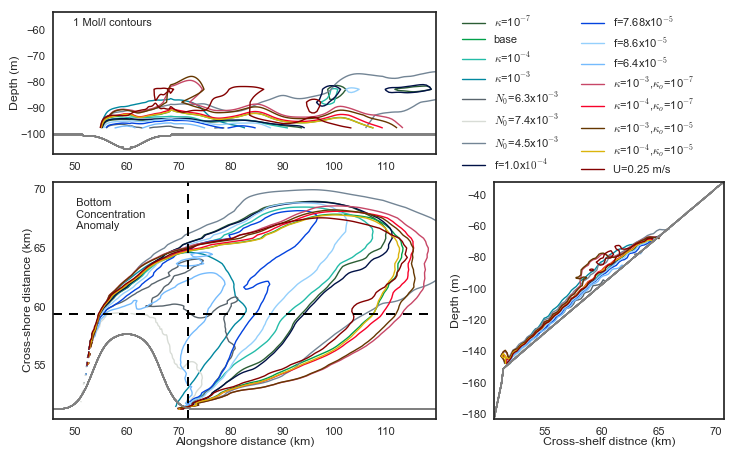

In [25]:
records2 = [records[0],
            records[2],
            #records[3],
            #records[14],
            #records[15],
            #records[16],
            #records[17],
            #records[1],
            ]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[2],
               #recordsNoC[3],
               #recordsNoC[14],
               #recordsNoC[15],
               #recordsNoC[16],
               #recordsNoC[17],
               #recordsNoC[1],
               ]

cmap_name = cmo.cm.balance
sns.set_context('notebook')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 2, height_ratios=[0.6,1], width_ratios=[1,0.6])


for rec,recNoC in zip(records,recordsNoC):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data,
                                                 grid.Depth.data)

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)
    print('done getting bottom concentrations')
    ax1=Plot1anom(gs0[0,0],ptracers.Tr1.isel(Y=yind),ptracersNoC.Tr1.isel(Y=yind),
              zslice,267,xslice,color=rec.color) # x-z contours conc

    ax2=Plot2anom(gs0[1,1],ptracers.Tr1.isel(X=xind),ptracersNoC.Tr1.isel(X=xind),
              yslice_bac,zslice_2,250,color=rec.color) # bottom concentration

    ax3=Plot3anom(gs0[1,0],np.ma.masked_array(ConcFilt-ConcFiltNoC,mask=maskExpandSB),
              tslice,xslice,yslice_bac,250,267,color=rec.color,label=rec.label)


ax1.set_ylabel('Depth (m)',labelpad=0.3)
ax1.text(0.05,0.9,'2 Mol/l contours',transform=ax1.transAxes)

ax2.set_ylabel('Depth (m)',labelpad=0.3)
ax2.set_xlabel('Cross-shelf distnce (km)',labelpad=0.3)
    
#ax2.text(0.2,0.02,'Tracer concentration Anomaly (Mol/l)',transform=ax2.transAxes)

ax3.text(0.05,0.8,' Bottom\n Concentration\n Anomaly',transform=ax3.transAxes)
ax3.set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax3.set_ylabel('Cross-shore distance (km)',labelpad=0.3)


plt.tight_layout()

plt.savefig('fig_PoolContours.pdf',format='pdf')


done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations
done getting bottom concentrations


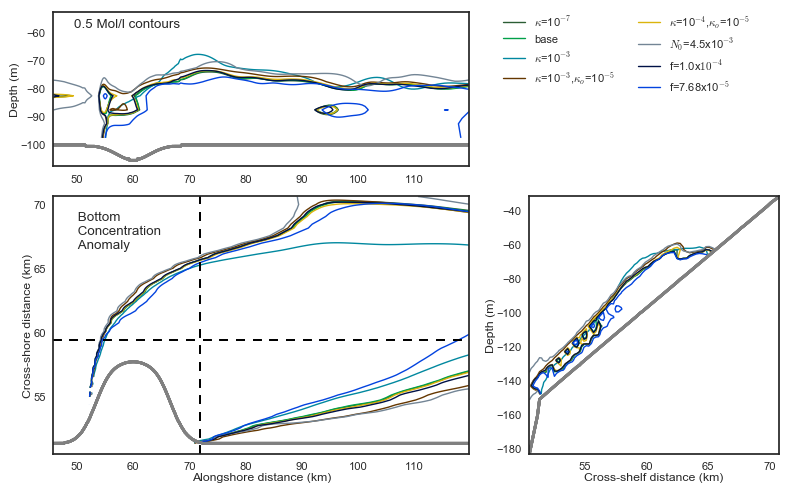

In [95]:
records2 = [records[0],
            records[1],
            records[3],
            records[13],
            records[14],
            records[6],
            records[7],
            records[8],
            ]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[1],
               recordsNoC[3],
               recordsNoC[13],
               recordsNoC[14],
               recordsNoC[6],
               recordsNoC[7],
               recordsNoC[8],
               ]

cmap_name = cmo.cm.balance
sns.set_context('paper')
sns.set_style('white')

#plt.rcParams['font.size'] = 8.0

#f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in
f = plt.figure(figsize = (8,5)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 2, height_ratios=[0.6,1], width_ratios=[1,0.6])


for rec,recNoC in zip(records2,recordsNoC2):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data,
                                                 grid.Depth.data)

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)
    print('done getting bottom concentrations')
    ax1=Plot1anom(gs0[0,0],ptracers.Tr1.isel(Y=yind),ptracersNoC.Tr1.isel(Y=yind),
              zslice,267,xslice,color=rec.color) # x-z contours conc

    ax2=Plot2anom(gs0[1,1],ptracers.Tr1.isel(X=xind),ptracersNoC.Tr1.isel(X=xind),
              yslice_bac,zslice_2,250,color=rec.color) # bottom concentration

    ax3=Plot3anom(gs0[1,0],np.ma.masked_array(ConcFilt-ConcFiltNoC,mask=maskExpandSB),
              tslice,xslice,yslice_bac,250,267,color=rec.color,label=rec.label)


ax1.set_ylabel('Depth (m)',labelpad=0.3)
ax1.text(0.05,0.9,'0.5 Mol/l contours',transform=ax1.transAxes)

ax2.set_ylabel('Depth (m)',labelpad=0.3)
ax2.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    
#ax2.text(0.2,0.02,'Tracer concentration Anomaly (Mol/l)',transform=ax2.transAxes)

ax3.text(0.05,0.8,' Bottom\n Concentration\n Anomaly',transform=ax3.transAxes)
ax3.set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax3.set_ylabel('Cross-shore distance (km)',labelpad=0.3)


plt.tight_layout()

plt.savefig('fig_PoolContours_selected.pdf',format='pdf')



## BAC timeseries

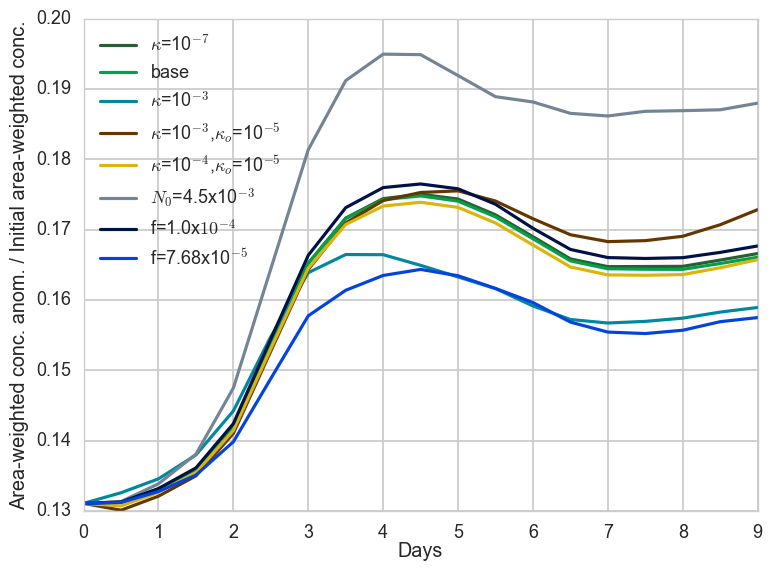

In [74]:
records2 = [records[0],
            records[1],
            records[3],
            records[13],
            records[14],
            records[6],
            records[7],
            records[8],
            ]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[1],
               recordsNoC[3],
               recordsNoC[13],
               recordsNoC[14],
               recordsNoC[6],
               recordsNoC[7],
               recordsNoC[8],
               ]

cmap_name = cmo.cm.balance
sns.set_context('talk')
sns.set_style('whitegrid')

#plt.rcParams['font.size'] = 8

f,ax = plt.subplots(1,1,figsize = (8,6)) # 19.0cm = 7.4in, 115cm = 4.52in

labels = []

for rec,recNoC in zip(records2,recordsNoC2):
    
    ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers = xr.open_dataset(ptracers_file)

    ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    ptracersNoC = xr.open_dataset(ptracersNoC_file)

    ConcAreaWeighted, ConcFilt, Area = ConcAreaShelf(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data,
                                                 grid.Depth.data)

    ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC = ConcAreaShelf(ptracersNoC.Tr1.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)
    
    
    BAC = [np.sum(np.sum((ConcAreaWeighted[:,yslice,xslice].data-ConcAreaWeightedNoC[:,yslice,xslice].data),
                         axis=1),axis=1)]
    BAC0 = np.sum(ConcAreaWeighted[0,yslice,xslice].data)
    
    
    CS = ax.plot(np.arange(19)/2,np.array(BAC)[0,:]/BAC0,
                 color=sns.xkcd_rgb[rec.color],
                 label=rec.label)
      
    labels.append(rec.label)

    
    


ax.set_xlabel('Days',labelpad=0.3)
ax.set_ylabel('Area-weighted conc. anom. / Initial area-weighted conc.')
plt.legend(labels,loc=0)
plt.tight_layout()
plt.show()
plt.savefig('fig_BAC_timeseries_selected.pdf',format='pdf')



(1, 19)


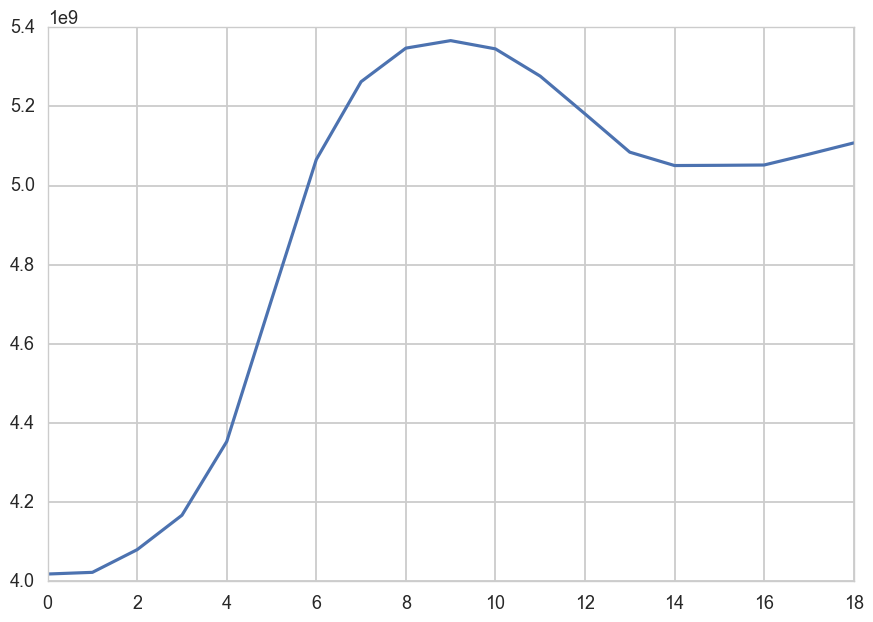